In [32]:
import os
import cv2
import inspect
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

os.chdir(r'/RG/rg-tal/orlev/Face-Recognition-Of-Masked-Faces')

from config_file import *
from helpers import get_model, read_images, get_1id_pose, resize_image, img_output_bbox, project_3d,head3d_z_dist, scale_int_array
from create_masks import render,bg_color,color_face_mask
img_src = '/RG/rg-tal/orlev/datasets/original_ds/CASIA-WebFace/0000099/015.jpg'
img_src = '/RG/rg-tal/orlev/datasets/original_ds/lfw/Paul_Lockhart/Paul_Lockhart_0001.jpg'
img_src = '/RG/rg-tal/orlev/datasets/original_ds/lfw/Jolanta_Kwasniewski/Jolanta_Kwasniewski_0002.jpg'

Model will use 1 GPUs!


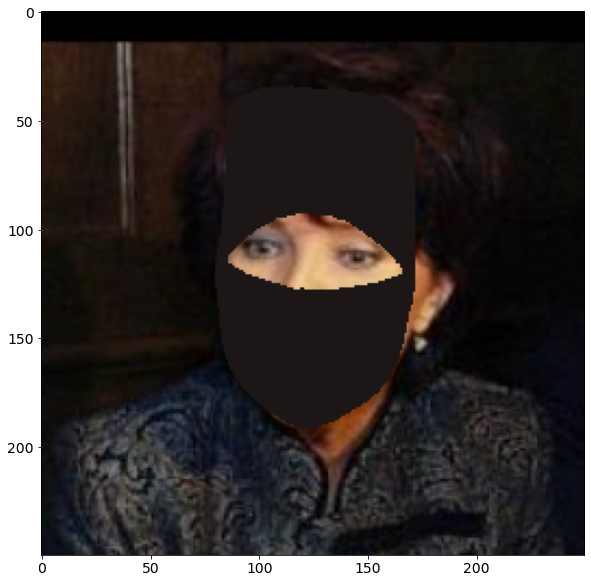

In [40]:

masks_to_create = masks_templates(ALL_MASKS)


# Get img2pose model
model, transform = get_model()
img = plt.imread(img_src, 1)
results = model.predict([transform(img)])[0]
pose, bbox = get_1id_pose(results, img, 0)

r_img, scale_factor = resize_image(img, bbox)

# output image selected area
output_bbox = img_output_bbox(img, bbox, 0.25, True)

# project 3D face according to pose
df_3dh = project_3d(r_img, pose)
h3d2i = head3d_z_dist(r_img, df_3dh)
masks_to_create = ['hatmask','eyemask']
for mask_name in masks_to_create:
    mask_x, mask_y, rest_mask_x, rest_mask_y = \
        render(img, r_img, df_3dh, h3d2i, mask_name, scale_factor, False, output_bbox, pose)
    
# The average color of the surrounding of the image
color = bg_color(mask_x, mask_y, img)
masked_image = color_face_mask(img, color, mask_x, mask_y, rest_mask_x, rest_mask_y, mask_name)
fig1 = plt.figure(figsize=(10, 10))
plt.tick_params(labelsize=14)
plt.imshow(masked_image)

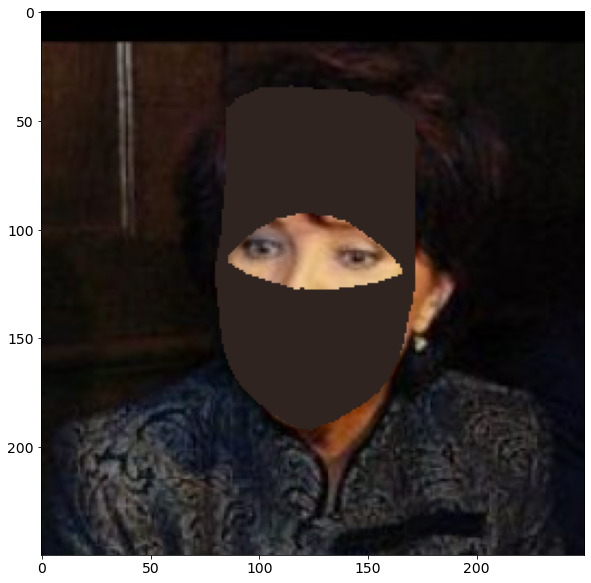

In [42]:
def all_bg_color(image):
    image_bg = image.copy()
    image_bg_effective_size = image_bg.shape[0] * image_bg.shape[1]
    image_bg[mask_y.astype(int), mask_x.astype(int), :] = [0, 0, 0]
    image_bg_blue = image[:, :, 0]
    image_bg_green = image[:, :, 1]
    image_bg_red = image[:, :, 2]
    image_bg_blue_val = np.sum(image_bg_blue) / image_bg_effective_size
    image_bg_green_val = np.sum(image_bg_green) / image_bg_effective_size
    image_bg_red_val = np.sum(image_bg_red) / image_bg_effective_size

    return [image_bg_blue_val, image_bg_green_val, image_bg_red_val]
color = all_bg_color(img)
masked_image = color_face_mask(img, color, mask_x, mask_y, rest_mask_x, rest_mask_y, mask_name)
fig1 = plt.figure(figsize=(10, 10))
plt.tick_params(labelsize=14)
plt.imshow(masked_image)

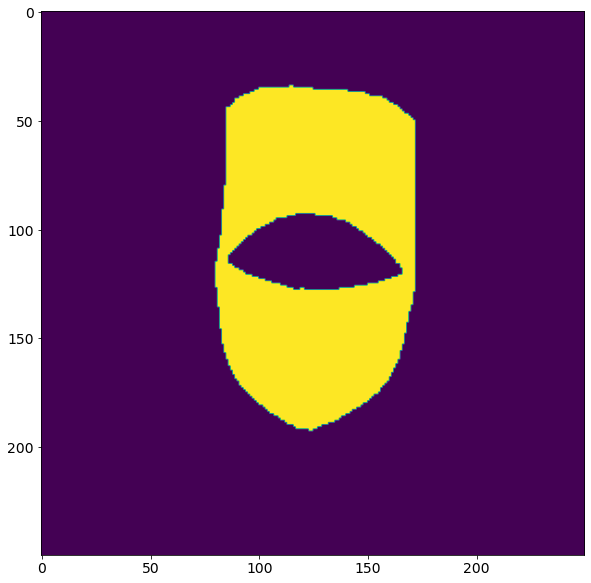

In [43]:
img_x_dim, img_y_dim = img.shape[1], img.shape[0]
mask_on_img_front = np.zeros((img_y_dim, img_x_dim))

for x, y in zip(mask_x, mask_y):
    mask_on_img_front[y, x] = 1

for x, y in zip(rest_mask_x, rest_mask_y):
    mask_on_img_front[y, x] = 0

fig1 = plt.figure(figsize=(10, 10))
plt.tick_params(labelsize=14)
plt.imshow(mask_on_img_front)